# [**Décompositions de jeux de données de visages**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/2_5_decomposition/plot_faces_decomposition.ipynb)<br/>([*Faces dataset decompositions*](https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html))

Cet exemple applique au [**jeu de données de visages d'Olivetti** (7.2)](https://scikit-learn.org/stable/datasets/real_world.html#olivetti-faces-dataset) différentes méthodes non supervisée de décomposition de matrice (réduction de dimension) du module [**`sklearn.decomposition`**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) (voir le chapitre de documentation [**Décomposition des signaux en composants (problèmes de factorisation de matrice)** (2.5)](https://scikit-learn.org/stable/modules/decomposition.html#decompositions)).

* Auteurs: Vlad Niculae, Alexandre Gramfort
* Licence: BSD 3 clause

# Préparation des données

Chargement et prétraitement du jeu de données de visages d'Olivetti.

In [1]:
import logging

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn import cluster
from sklearn import decomposition

rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (focus on one sample, centering all features)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


Définir une fonction de base pour tracer la galerie de visages.

In [2]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

Regardons nos données. La couleur grise indique des valeurs négatives, la couleur blanche indique des valeurs positives.

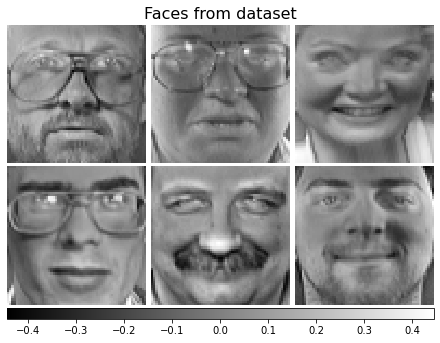

In [3]:
plot_gallery("Faces from dataset", faces_centered[:n_components])

# Décomposition

Initialisez différents estimateurs pour la décomposition et ajustez chacun d'eux sur toutes les images et tracez certains résultats. Chaque estimateur extrait 6 composants en tant que vecteurs $h \in \mathbb{R}^{4096}$. Nous avons simplement affiché ces vecteurs dans une visualisation compréhensible pour l'homme en tant qu'images de 64x64 pixels.

En savoir plus dans le [**Guide de l'utilisateur** (2.5)](https://scikit-learn.org/stable/modules/decomposition.html#decompositions).

## Visages propres - ACP en utilisant SVD aléatoire

Réduction de dimensionnalité linéaire en utilisant la décomposition en valeurs singulières (SVD) des données pour projeter sur un espace de dimension inférieure.

**Note**

L'estimateur Visages propres, via [**`sklearn.decomposition.PCA`**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), fournit également un scalaire `noise_variance` (la moyenne de la variance pixel par pixel) qui ne peut pas être affichée en tant qu'image.

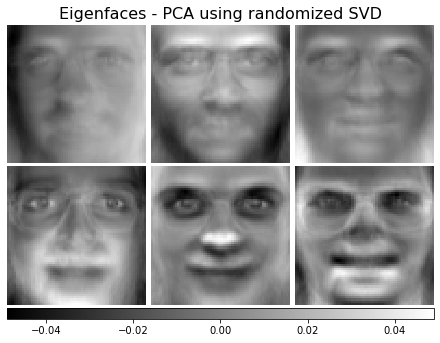

In [4]:
pca_estimator = decomposition.PCA(
    n_components=n_components, svd_solver="randomized", whiten=True
)
pca_estimator.fit(faces_centered)
plot_gallery(
    "Eigenfaces - PCA using randomized SVD", pca_estimator.components_[:n_components]
)

## Composants non négatifs - NMF

Estimez les données d'origine non négatives en tant que production de deux matrices non négatives.

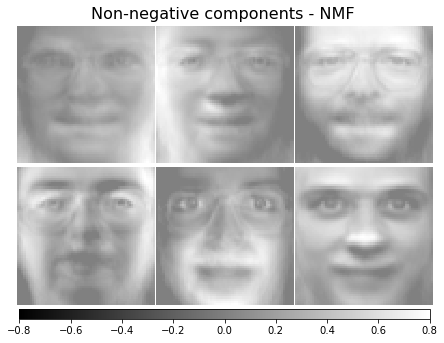

In [5]:
nmf_estimator = decomposition.NMF(n_components=n_components, tol=5e-3)
nmf_estimator.fit(faces)  # original non- negative dataset
plot_gallery("Non-negative components - NMF", nmf_estimator.components_[:n_components])

## Composants indépendants - FastICA

L'analyse de composants indépendants sépare les vecteurs multivariés en sous-composants additifs qui sont maximaux indépendants.

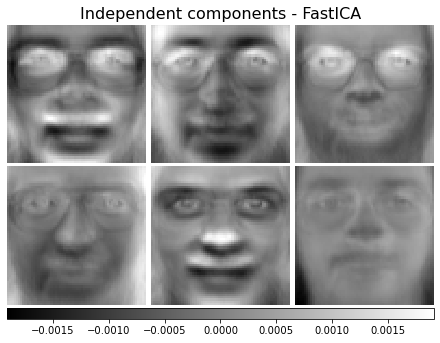

In [6]:
ica_estimator = decomposition.FastICA(
    n_components=n_components, max_iter=400, whiten="arbitrary-variance", tol=15e-5
)
ica_estimator.fit(faces_centered)
plot_gallery(
    "Independent components - FastICA", ica_estimator.components_[:n_components]
)

## Composants épars - MiniBatchSparsePCA

La PCA creuse en mini-lots (`MiniBatchSparsePCA`) extrait l'ensemble des composants creux qui reconstituent le mieux les données. Cette variante est plus rapide mais moins précise que la [**`sklearn.decomposition.SparsePCA`**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html) similaire.

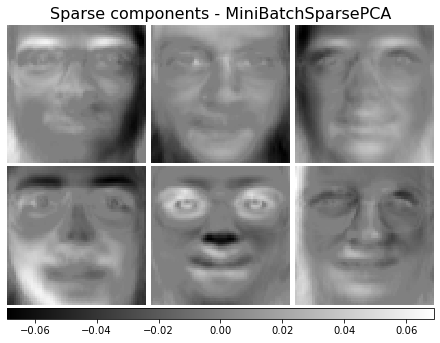

In [8]:
batch_pca_estimator = decomposition.MiniBatchSparsePCA(
    n_components=n_components, alpha=0.1, n_iter=100, batch_size=3, random_state=rng
)
batch_pca_estimator.fit(faces_centered)
plot_gallery(
    "Sparse components - MiniBatchSparsePCA",
    batch_pca_estimator.components_[:n_components],
)

## Apprentissage de dictionnaire

Par défaut, `MiniBatchDictionaryLearning` divise les données en mini-lots et optimise de manière en ligne en parcourant les mini-lots pour le nombre d'itérations spécifié.

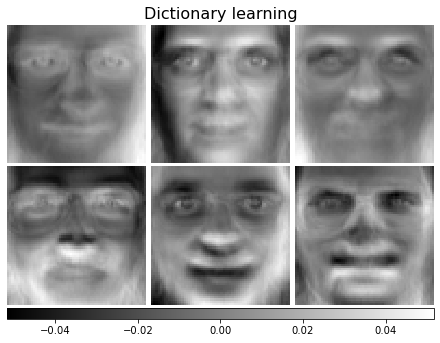

In [9]:
batch_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components, alpha=0.1, max_iter=50, batch_size=3, random_state=rng
)
batch_dict_estimator.fit(faces_centered)
plot_gallery("Dictionary learning", batch_dict_estimator.components_[:n_components])

## Centres de cluster - MiniBatchKMeans

`MiniBatchKMeans` est efficace en termes de calcul et met en œuvre l'apprentissage en ligne avec une méthode `partial_fit`. C'est pourquoi il pourrait être bénéfique d'améliorer certains algorithmes coûteux en termes de temps avec `MiniBatchKMeans`.

In [10]:
kmeans_estimator = cluster.MiniBatchKMeans(
    n_clusters=n_components,
    tol=1e-3,
    batch_size=20,
    max_iter=50,
    random_state=rng,
    n_init="auto",
)
kmeans_estimator.fit(faces_centered)
plot_gallery(
    "Cluster centers - MiniBatchKMeans",
    kmeans_estimator.cluster_centers_[:n_components],
)

TypeError: '<=' not supported between instances of 'str' and 'int'

## Composants d'analyse factorielle - FA

L'analyse factorielle est similaire à l'`ACP` mais a l'avantage de modéliser la variance dans chaque direction de l'espace d'entrée indépendamment (bruit hétéroscédastique). En savoir plus dans le [**Guide de l'utilisateur** (2.5.5)](https://scikit-learn.org/stable/modules/decomposition.html#fa).

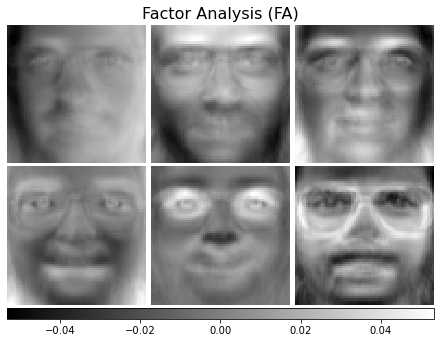

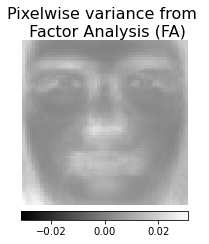

In [12]:
fa_estimator = decomposition.FactorAnalysis(n_components=n_components, max_iter=20)
fa_estimator.fit(faces_centered)
plot_gallery("Factor Analysis (FA)", fa_estimator.components_[:n_components])

# --- Pixelwise variance
plt.figure(figsize=(3.2, 3.6), facecolor="white", tight_layout=True)
vec = fa_estimator.noise_variance_
vmax = max(vec.max(), -vec.min())
plt.imshow(
    vec.reshape(image_shape),
    cmap=plt.cm.gray,
    interpolation="nearest",
    vmin=-vmax,
    vmax=vmax,
)
plt.axis("off")
plt.title("Pixelwise variance from \n Factor Analysis (FA)", size=16, wrap=True)
plt.colorbar(orientation="horizontal", shrink=0.8, pad=0.03)
plt.show()

# Décomposition : Apprentissage de dictionnaire

Dans la section suivante, considérons de manière plus précise l'[**apprentissage de dictionnaire** (2.5.4)](https://scikit-learn.org/stable/modules/decomposition.html#dictionarylearning). L'apprentissage de dictionnaire est un problème qui consiste à trouver une représentation creuse des données d'entrée en tant que combinaison d'éléments simples. Ces éléments simples forment un dictionnaire. Il est possible de contraindre le dictionnaire et/ou les coefficients de codage à être positifs pour correspondre aux contraintes qui peuvent être présentes dans les données.

`MiniBatchDictionaryLearning` met en œuvre une version plus rapide mais moins précise de l'algorithme d'apprentissage de dictionnaire qui convient mieux aux grands jeux de données. En savoir plus dans le [**Guide de l'utilisateur** (2.5.4.3)](https://scikit-learn.org/stable/modules/decomposition.html#minibatchdictionarylearning).

Tracez les mêmes échantillons de notre jeu de données mais avec une autre carte de couleurs. Le rouge indique les valeurs négatives, le bleu indique les valeurs positives et le blanc représente les zéros.

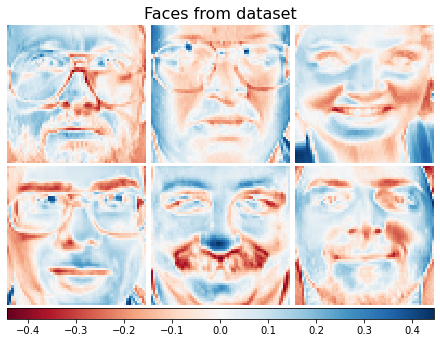

In [13]:
plot_gallery("Faces from dataset", faces_centered[:n_components], cmap=plt.cm.RdBu)

Similaire aux exemples précédents, nous changeons les paramètres et entraînons l'estimateur `MiniBatchDictionaryLearning` sur toutes les images. En général, l'apprentissage de dictionnaire et la décomposition en codage creux décomposent les données d'entrée en matrices de dictionnaire et de coefficients de codage $X \approx UV$, où $X = [x_1, . . . , x_n]$, $X \in \mathbb{R}^{m×n}$, dictionnaire $U \in \mathbb{R}^{m×k}$, coefficients de codage $V \in \mathbb{R}^{k×n}$.

Ci-dessous se trouvent également les résultats lorsque les matrices de dictionnaire et de coefficients de codage sont contraints de manière positive.

## Apprentissage de dictionnaire - dictionnaire positif

Dans la section suivante, nous imposons la positivité lors de la recherche du dictionnaire.

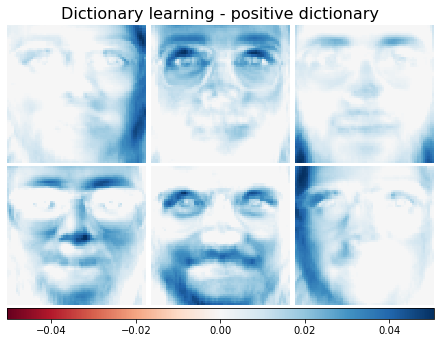

In [14]:
dict_pos_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    random_state=rng,
    positive_dict=True,
)
dict_pos_dict_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary",
    dict_pos_dict_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

## Apprentissage de dictionnaire - code positif

Ci-dessous, nous imposons les coefficients de codage en tant que matrice positive.

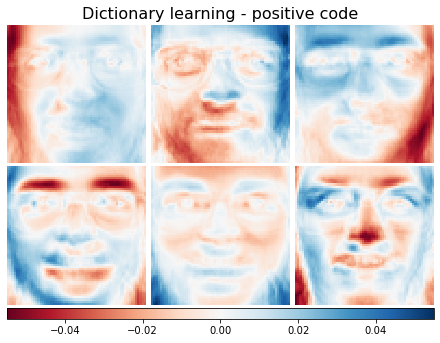

In [15]:
dict_pos_code_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_code=True,
)
dict_pos_code_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive code",
    dict_pos_code_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

## Apprentissage de dictionnaire - dictionnaire et code positifs

Ci-dessous se trouvent également les résultats si les valeurs de dictionnaire et les coefficients de codage sont contraints de manière positive

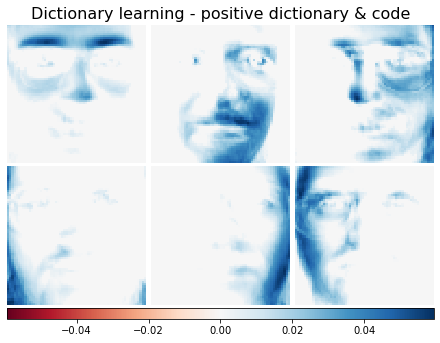

In [16]:
dict_pos_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_dict=True,
    positive_code=True,
)
dict_pos_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary & code",
    dict_pos_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)